In [38]:
import numpy as np
import pandas as pd

Cleaning train dataset

In [39]:
train_df = pd.read_csv("./twitter_training.csv")
absurd = train_df.columns[3]

train_df.rename(columns = {
    'Positive' : 'Label',
    absurd : 'text'
}, inplace=True)

train_df.drop(columns=['Borderlands', '2401'], inplace=True)
train_df.head()

,Label,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [40]:
train_df['Label'].value_counts()

Label
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [41]:
print(f"Null Rows:\n{train_df.isnull().sum()}\n")
print(f"Duplicated Rows: {int(train_df.duplicated().sum())}")


Null Rows:
Label      0
text     686
dtype: int64

Duplicated Rows: 4909


In [42]:
print("Percentage of Empty and duplicated rows: ", round(
    int(train_df.isnull().sum()['text'] + train_df.duplicated().sum()) * 100 / len(train_df),
    3), "%")


Percentage of Empty and duplicated rows:  7.492 %


#### Since the empty and duplicated needs to be delt with, we shall drop it

In [43]:
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)

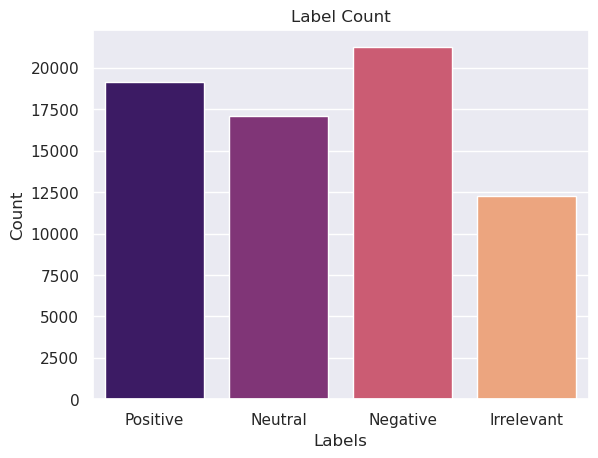

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = 'darkgrid')
sns.countplot(data = train_df, x=train_df['Label'], hue=train_df['Label'], palette='magma')
plt.title('Label Count')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.show()

#### Encoding the Labels

In [45]:
train_df['Sentiment'] = train_df['Label'].replace({
    'Irrelevant' : 0,
    'Neutral' : 1,
    'Negative' : 2,
    'Positive' : 3 
})
train_df.head()

/tmp/ipykernel_7093/1263614908.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['Sentiment'] = train_df['Label'].replace({


,Label,text,Sentiment
0,Positive,I am coming to the borders and I will kill you...,3
1,Positive,im getting on borderlands and i will kill you ...,3
2,Positive,im coming on borderlands and i will murder you...,3
3,Positive,im getting on borderlands 2 and i will murder ...,3
4,Positive,im getting into borderlands and i can murder y...,3


Cleaning validation dataset

In [46]:
val_df = pd.read_csv('./twitter_validation.csv')
absurd2 = val_df.columns[3]
val_df.rename(columns = {
    'Irrelevant' : 'Label',
    absurd2 : 'text'
}, inplace=True)
val_df.drop(columns=['Facebook', '3364'], inplace=True)
val_df['Sentiment'] = val_df['Label'].replace({
    'Irrelevant' : 0,
    'Neutral' : 1,
    'Negative' : 2,
    'Positive' : 3 
})

val_df.head()

/tmp/ipykernel_7093/4054578065.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['Sentiment'] = val_df['Label'].replace({


,Label,text,Sentiment
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,1
1,Negative,@Microsoft Why do I pay for WORD when it funct...,2
2,Negative,"CSGO matchmaking is so full of closet hacking,...",2
3,Neutral,Now the President is slapping Americans in the...,1
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,2


In [47]:
val_df.duplicated().sum()

1

In [48]:
val_df.isnull().sum()

Label        0
text         0
Sentiment    0
dtype: int64

In [49]:
val_df.shape

(999, 3)

# MODEL TIME!!!

In [50]:
# Import necessary libraries
from sklearn.model_selection import train_test_split as tts
from transformers import TFBertForSequenceClassification, AdamWeightDecay
import tensorflow as tf

In [51]:
size = 4

In [52]:
train_df, test_df = tts(train_df, test_size=0.2, random_state=42)

In [53]:
from transformers import BertTokenizerFast
import tensorflow as tf

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Tokenize texts
train_encodings = tokenizer(list(train_df["text"]), truncation=True, padding=True)
val_encodings = tokenizer(list(val_df["text"]), truncation=True, padding=True)

# Convert to tf.data.Dataset
train_df = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"]
    },
    list(train_df["Label"])
)).batch(size)

val_df = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": val_encodings["input_ids"],
        "attention_mask": val_encodings["attention_mask"]
    },
    list(val_df["Label"])
)).batch(size)


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Load the model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

# Use AdamWeightDecay optimizer
optimizer = AdamWeightDecay(learning_rate=3e-5, weight_decay_rate=0.01)

# Loss function
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])


In [56]:
model.fit(train_df['text'],train_df['Sentiment'],
          batch_size=size,
          validation_data=val_df,
          epochs=3)

TypeError: '_BatchDataset' object is not subscriptable